In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(r'C:\Users\HP\Downloads\netflix.csv', encoding='latin1')


# Preview the data
df.head()


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [2]:
print(df.columns)


Index(['show_id', 'type', 'title', 'director', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in'],
      dtype='object')


In [3]:
# Fill missing values in valid text fields
df.fillna({'director': 'Unknown', 'description': 'No description available'}, inplace=True)

# Drop any rows without titles
df.dropna(subset=['title'], inplace=True)

# Convert date_added to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')


In [4]:
print(df.columns.tolist())


['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in']


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Use 'listed_in' (genres/tags) for recommendations
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['listed_in'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Map titles to index
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

# Recommendation function
def recommend(title, num=5):
    idx = indices.get(title)
    if idx is None:
        return "Title not found in dataset."
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores[1:num+1]]
    return df['title'].iloc[sim_indices]


In [6]:
recommend("Narcos")


7219        Queen of the South
7342            Altered Carbon
7356            Narcos: Mexico
7656                   Shooter
7670    Marvel's Jessica Jones
Name: title, dtype: object

In [7]:
# 1. Find Narcos’s index
narcos_idx = indices['Narcos']

# 2. Extract its TF-IDF vector (sparse format)
narcos_vec = tfidf_matrix[narcos_idx]


In [8]:
import numpy as np

# Get the feature names (genre tokens)
feature_names = tfidf.get_feature_names_out()

# Convert to a dense array and flatten
dense_weights = narcos_vec.toarray().flatten()

# List only the non-zero entries: genres that apply to Narcos
narcos_terms = [
    (feature_names[i], w)
    for i, w in enumerate(dense_weights)
    if w > 0
]

print("Narcos’s TF-IDF weights by genre:")
for term, weight in narcos_terms:
    print(f"  • {term}: {weight:.3f}")


Narcos’s TF-IDF weights by genre:
  • action: 0.330
  • adventure: 0.330
  • crime: 0.412
  • dramas: 0.211
  • shows: 0.272
  • tv: 0.703


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# 1. Define extra stop words
extra_stops = {'tv', 'shows'}

# 2. Merge with built-in English stop words, then cast to list
all_stops = list(ENGLISH_STOP_WORDS.union(extra_stops))

# 3. Rebuild the vectorizer—now stop_words is a list, so sklearn is happy
tfidf = TfidfVectorizer(stop_words=all_stops,
                        ngram_range=(1,1))
tfidf_matrix = tfidf.fit_transform(df['listed_in'])


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Recompute similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 2. Inspect Narcos’s cleaned TF-IDF weights
idx      = indices['Narcos']
vec      = tfidf_matrix[idx].toarray().flatten()
terms    = tfidf.get_feature_names_out()
weights  = [(terms[i], w) for i, w in enumerate(vec) if w>0]
weights  = sorted(weights, key=lambda x: -x[1])

print("Cleaned Narcos TF-IDF weights:")
for term, w in weights:
    print(f" • {term}: {w:.3f}")

# 3. Get new recommendations
print("\nNew recs for Narcos:")
for i, title in enumerate(recommend("Narcos"), 1):
    print(f"{i}. {title}")


Cleaned Narcos TF-IDF weights:
 • crime: 0.627
 • action: 0.502
 • adventure: 0.502
 • dramas: 0.321

New recs for Narcos:
1. Queen of the South
2. Altered Carbon
3. Narcos: Mexico
4. Shooter
5. Marvel's Jessica Jones


In [12]:
#Capture Compound Genres with Bigrams
tfidf_ng = TfidfVectorizer(stop_words=all_stops, ngram_range=(1,2))
matrix_ng = tfidf_ng.fit_transform(df['listed_in'])
cosine_sim_ng = cosine_similarity(matrix_ng, matrix_ng)

# Update recommend function for n-grams
def recommend_ng(title, num=5):
    idx = indices.get(title)
    if idx is None:
        return []
    sims = list(enumerate(cosine_sim_ng[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)
    recs = [df['title'].iloc[i] for i, _ in sims[1:num+1]]
    return recs

print("Bigrams-based recs for Narcos:", recommend_ng("Narcos"))


Bigrams-based recs for Narcos: ['Queen of the South', 'Altered Carbon', 'Narcos: Mexico', 'Shooter', "Marvel's Jessica Jones"]


In [13]:
import re

def comma_tokenizer(text):
    # Split on commas, strip whitespace, lowercase
    return [t.strip().lower().replace(' & ', '_') for t in text.split(',')]

tfidf_custom = TfidfVectorizer(
    tokenizer=comma_tokenizer,
    stop_words=all_stops, 
    lowercase=True
)
matrix_custom = tfidf_custom.fit_transform(df['listed_in'])


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
from sklearn.preprocessing import MinMaxScaler

# Normalize release_year
year_norm = MinMaxScaler().fit_transform(df[['release_year']]).flatten()

def recommend_hybrid(title, num=5, alpha=0.7):
    idx = indices[title]
    sims = cosine_similarity(matrix_custom, matrix_custom)[idx]
    scores = alpha * sims + (1-alpha) * year_norm
    top_idxs = scores.argsort()[-num-1:-1][::-1]
    return df['title'].iloc[top_idxs].tolist()


Cluster 0: ['independent movies', 'dramas', 'international movies', 'comedies', 'thrillers']
Cluster 1: ['dramas', 'international movies', 'action_adventure', 'thrillers', 'stand-up comedy']
Cluster 2: ['international tv shows', 'tv dramas', 'tv comedies', 'romantic tv shows', 'crime tv shows']
Cluster 3: ['documentaries', 'international movies', 'music_musicals', 'sports movies', 'lgbtq movies']
Cluster 4: ['docuseries', 'reality tv', 'international tv shows', 'british tv shows', 'science_nature tv']
Cluster 5: ['comedies', 'international movies', 'dramas', 'children_family movies', 'romantic movies']


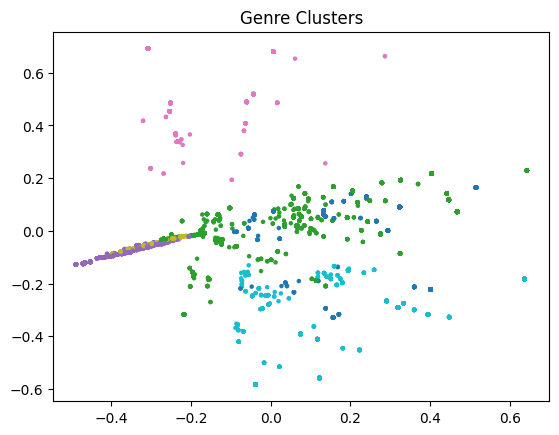

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Cluster on your custom matrix
kmeans = KMeans(n_clusters=6, random_state=42)
df['cluster'] = kmeans.fit_predict(matrix_custom)

# Label clusters by top terms
terms = tfidf_custom.get_feature_names_out()
centers = kmeans.cluster_centers_
for i,c in enumerate(centers):
    top5 = c.argsort()[-5:][::-1]
    print(f"Cluster {i}:", [terms[j] for j in top5])

# Visualize clusters
coords = PCA(2).fit_transform(matrix_custom.toarray())
plt.scatter(coords[:,0], coords[:,1], c=df['cluster'], s=5, cmap='tab10')
plt.title("Genre Clusters")
plt.show()


In [16]:
#Normalize Column Names
#Unify casing and whitespace so later references match:
df.columns = (
  df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)


In [17]:
df['director'] = df['director'].fillna('Unknown')


In [18]:
#Inspect Your Columns
#Before any fills, confirm exactly what Pandas sees:
# Right after loading
print(df.columns.tolist())


['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'cluster']


In [19]:
#Handle Non-existent Columns, 
#Choose one of two approaches:

#Skip them entirely

defaults = {
  'director':    'Unknown',
  'cast':        'Unknown',
  'description': 'No description'
}

for col, fill in defaults.items():
    if col in df.columns:
        df[col] = df[col].fillna(fill)
    else:
        print(f"Skipping missing column: {col}")


Skipping missing column: cast
Skipping missing column: description


In [20]:
#Create placeholders so downstream code never breaks

if 'cast' not in df.columns:
    df['cast'] = 'Unknown'
else:
    df['cast'] = df['cast'].fillna('Unknown')

if 'description' not in df.columns:
    df['description'] = 'No description'


In [21]:
#Consolidated Cleaning Snippet

# Normalize column names
df.columns = (
  df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Impute director (exists) and guarantee cast/description
df['director'] = df['director'].fillna('Unknown')

if 'cast' in df.columns:
    df['cast'] = df['cast'].fillna('Unknown')
else:
    df['cast'] = 'Unknown'

if 'description' in df.columns:
    df['description'] = df['description'].fillna('No description')
else:
    df['description'] = 'No description'

# Drop rows missing essential title
df = df.dropna(subset=['title'])

# Parse dates and validate
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
print("Invalid date entries:", df['date_added'].isna().sum())

# Quick null-check on key fields
print(df[['director','cast','description']].isna().sum())


Invalid date entries: 0
director       0
cast           0
description    0
dtype: int64


In [22]:
#Validate & Snapshot Your Clean Data
#Preview your DataFrame
#Check types, non-null counts, glimpse sample rows.

df.info()
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8790 non-null   object        
 1   type          8790 non-null   object        
 2   title         8790 non-null   object        
 3   director      8790 non-null   object        
 4   country       8790 non-null   object        
 5   date_added    8790 non-null   datetime64[ns]
 6   release_year  8790 non-null   int64         
 7   rating        8790 non-null   object        
 8   duration      8790 non-null   object        
 9   listed_in     8790 non-null   object        
 10  cluster       8790 non-null   int32         
 11  cast          8790 non-null   object        
 12  description   8790 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(10)
memory usage: 858.5+ KB


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,cluster,cast,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,3,Unknown,No description
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",2,Unknown,No description
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",2,Unknown,No description
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",5,Unknown,No description
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",0,Unknown,No description


In [23]:
#Summarize key fields
#Spot any remaining oddities in numeric or categorical columns.

df.describe(include='all').T


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
show_id,8790,8790,s1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,8790,2,Movie,6126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,8790,8785,,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,8790,4528,Not Given,2588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,8790,86,United States,3240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,8790,NaN,NaN,NaN,2019-05-17 21:44:01.638225408,2008-01-01 00:00:00,2018-04-06 00:00:00,2019-07-03 00:00:00,2020-08-19 18:00:00,2021-09-25 00:00:00,NaN
release_year,8790.0,NaN,NaN,NaN,2014.183163,1925.0,2013.0,2017.0,2019.0,2021.0,8.825466
rating,8790,14,TV-MA,3205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,8790,220,1 Season,1791,NaN,NaN,NaN,NaN,NaN,NaN,NaN
listed_in,8790,513,"Dramas, International Movies",362,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#Clean title field
mask = df['title'].str.contains(r'[\x00-\x1F]')
df[mask]


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,cluster,cast,description
287,s2640,TV Show, ,Not Given,Pakistan,2020-04-25,2019,TV-14,1 Season,"International TV Shows, TV Dramas",2,Unknown,No description
459,s4915,TV Show,,Not Given,Pakistan,2018-04-27,2016,TV-14,1 Season,"International TV Shows, TV Dramas",2,Unknown,No description
519,s5788,Movie,"Katarzyna Piasecka, Rafa Pacze Seriously Funny",Not Given,Pakistan,2016-09-19,2016,TV-MA,65 min,Stand-Up Comedy,1,Unknown,No description
520,s5789,Movie,"Mariusz Kaamaga, Karol Kopiec, Wiolka Walaszc...",Not Given,Pakistan,2016-09-19,2016,TV-MA,69 min,Stand-Up Comedy,1,Unknown,No description
521,s5790,Movie,"Rafa Bana, Micha Leja Laugh out Loud",Not Given,Pakistan,2016-09-19,2016,TV-MA,64 min,Stand-Up Comedy,1,Unknown,No description
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8148,s5384,TV Show,Kings War,Not Given,China,2017-07-07,2012,TV-14,1 Season,"International TV Shows, TV Dramas",2,Unknown,No description
8289,s5787,Movie,"Karol Modzelewski, ukasz Lotek Lodkowski No...",Not Given,Pakistan,2016-09-19,2016,TV-MA,65 min,Stand-Up Comedy,1,Unknown,No description
8321,s5979,TV Show,ubat,Not Given,Turkey,2017-01-17,2013,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas",2,Unknown,No description
8346,s6178,TV Show,,Not Given,Japan,2018-12-23,2012,TV-Y7,2 Seasons,"Anime Series, Kids' TV",1,Unknown,No description


In [25]:
#Split & explode multi-valued columns

#Genres (listed_in)

df_genres = (df['listed_in']
               .str.split(', ')
               .explode()
               .value_counts()
               .rename_axis('genre')
               .reset_index(name='count'))


In [26]:
#Parse duration
df[['length','unit']] = df['duration'].str.extract(r'(\d+)\s*(\w+)')
df['length'] = df['length'].astype(int)


In [27]:
#Extract date features
df['added_year']  = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month


In [28]:
#Auto-detect with chardet

import chardet

# 1. Read a chunk of raw bytes
raw = open(r'C:\Users\HP\Downloads\netflix.csv', 'rb').read(10_000)

# 2. Ask chardet what it thinks
enc = chardet.detect(raw)['encoding']
print("Guessed encoding:", enc)

# 3. Reload using that encoding
df = pd.read_csv(r'C:\Users\HP\Downloads\netflix.csv', encoding=enc, parse_dates=['date_added'])


Guessed encoding: ISO-8859-1


In [29]:
#Reload with the Correct Encoding
#It looks like your file is ISO-8859-1 (latin1), 
#but many Windows exports actually use Windows-1252 (cp1252). Let’s try both:
#After loading, immediately inspect a few titles:
import pandas as pd

# Option 1: cp1252 (most Windows-encoded CSVs)
df = pd.read_csv(
    r'C:\Users\HP\Downloads\netflix.csv',
    encoding='cp1252',
    parse_dates=['date_added']
)

# Option 2: explicitly ISO-8859-1 / latin1
# df = pd.read_csv(
#     r'C:\Users\HP\Downloads\netflix.csv',
#     encoding='latin1',
#     parse_dates=['date_added']
# )


In [30]:
#Titles Are Now Legible – Here’s What to Tackle Next
#Your title column is looking perfect:

print(df['title'].head(10).tolist())


['Dick Johnson Is Dead', 'Ganglands', 'Midnight Mass', 'Confessions of an Invisible Girl', 'Sankofa', 'The Great British Baking Show', 'The Starling', 'Motu Patlu in the Game of Zones', 'Je Suis Karl', 'Motu Patlu in Wonderland']


In [31]:
print(df.columns.tolist())
# ['show_id', 'type', 'title', 'director', 'country',
#  'date_added', 'release_year', 'rating', 'duration', 'listed_in']


['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in']


In [32]:
#Extract Both Columns in One Step
#After this, df.columns will include length and unit—no more KeyError.

# This returns a DataFrame with two unnamed columns (0 and 1)
extracted = df['duration'].str.extract(r'(\d+)\s*(\w+)', expand=True)

# Rename them to meaningful labels
extracted.columns = ['length', 'unit']

# Convert length to integer
extracted['length'] = extracted['length'].astype(int)

# Standardize units
extracted['unit'] = (
  extracted['unit']
    .str.lower()
    .replace({'min': 'minutes', 'mins': 'minutes',
              'season': 'season', 'seasons': 'season'})
)

# Merge back into your original DataFrame
df = df.join(extracted)


In [33]:
#Quick One-Liner Alternative
#If you prefer piping directly into df:

df[['length','unit']] = (
  df['duration']
    .str.extract(r'(\d+)\s*(\w+)', expand=True)
    .pipe(lambda d: d.rename(columns={0:'length',1:'unit'}))
)

# Then fix types and labels
df['length'] = df['length'].astype(int)
df['unit']   = df['unit'].str.lower() \
  .replace({'min':'minutes','season':'season','seasons':'season'})


In [34]:
#Verify Your New Columns
#If you see numeric length and cleaned unit, you’re all set.

print(df.columns.tolist())
# […] 'duration', 'listed_in', 'length', 'unit']

df[['duration','length','unit']].head()


['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'length', 'unit']


,duration,length,unit
0,90 min,90,minutes
1,1 Season,1,season
2,1 Season,1,season
3,91 min,91,minutes
4,125 min,125,minutes


In [35]:
#Next: Turn length & unit into Insights
#You now have clean numeric runtimes (length) and normalized units (unit). 
#Let’s leverage those to answer key questions:

#Runtime Distributions
#1.1 Summary Statistics

# Overall by unit
print(df.groupby('unit')['length'].describe())


          count       mean        std  min   25%   50%    75%    max
unit                                                                
minutes  6126.0  99.584884  28.283225  3.0  87.0  98.0  114.0  312.0
season   2664.0   1.751877   1.550622  1.0   1.0   1.0    2.0   17.0


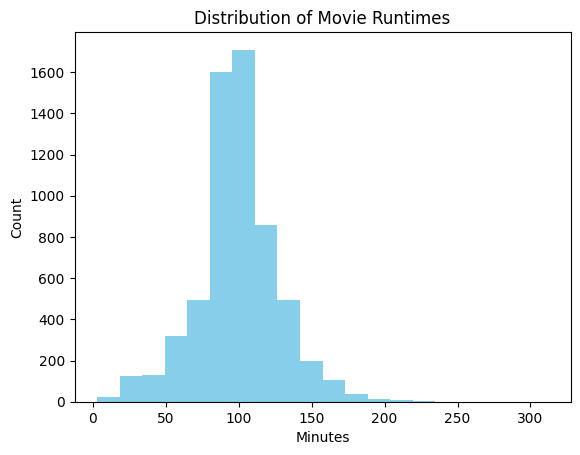

In [36]:
#1.2 Histograms

import matplotlib.pyplot as plt

# Movie runtimes only
movies = df[df['unit']=='minutes']
plt.hist(movies['length'], bins=20, color='skyblue')
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.show()


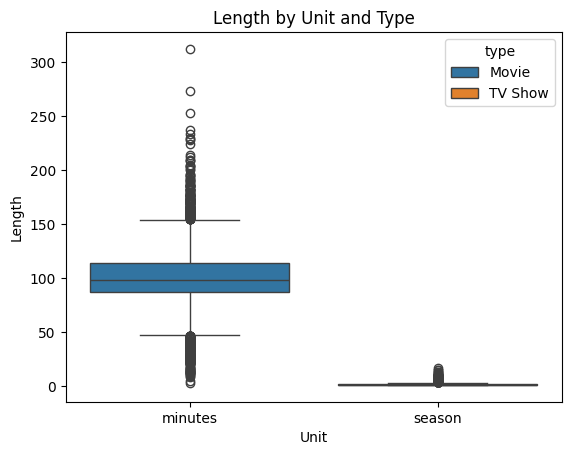

In [37]:
#2. Compare Movies vs. TV Seasons
#A boxplot quickly shows how seasons (in “length” = number of seasons) differ from movie runtimes:

import seaborn as sns

# Filter to only movies vs. TV Shows (minutes vs. seasons)
sns.boxplot(
    data=df[df['unit'].isin(['minutes','season'])],
    x='unit', y='length', hue='type'
)
plt.title('Length by Unit and Type')
plt.xlabel('Unit')
plt.ylabel('Length')
plt.show()


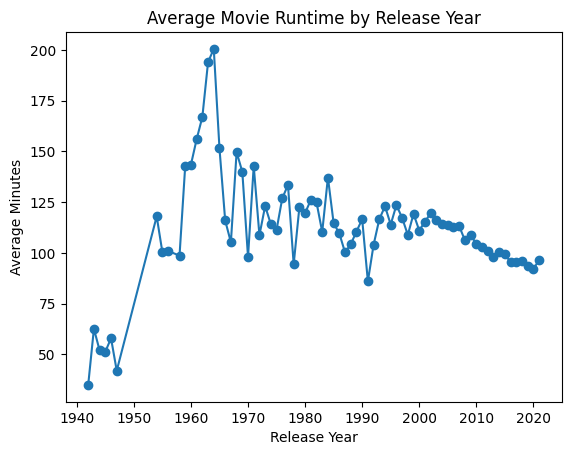

In [38]:
#3. Trend of Runtimes Over Time
#Are movies getting longer or shorter?

# Average movie runtime by release year
movie_trends = (
    movies
      .groupby('release_year')['length']
      .mean()
      .dropna()
)
movie_trends.plot(kind='line', marker='o')
plt.title('Average Movie Runtime by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average Minutes')
plt.show()


In [39]:
#Dive into Runtime Distributions
#With your length (numeric) and unit (“minutes” vs. “season”) columns in place, let’s:

#Generate summary statistics

#Plot histograms for each unit

#1. Summary Statistics


# Overall summary
print("Overall Runtime Summary:\n", df['length'].describe())

# Summary by unit
print("\nSummary by Unit:")
print(df.groupby('unit')['length'].describe())

# Summary by type (just for minutes)
print("\nMovie Runtime by Type (minutes only):")
print(df[df['unit']=='minutes'].groupby('type')['length'].describe())

#This gives you count, mean, std, min/max, and quartiles for:

#All runtimes

#Minutes vs. seasons

#Movie vs. TV Show when measured in minutes


Overall Runtime Summary:
 count    8790.000000
mean       69.934471
std        50.794433
min         1.000000
25%         2.000000
50%        88.500000
75%       106.000000
max       312.000000
Name: length, dtype: float64

Summary by Unit:
          count       mean        std  min   25%   50%    75%    max
unit                                                                
minutes  6126.0  99.584884  28.283225  3.0  87.0  98.0  114.0  312.0
season   2664.0   1.751877   1.550622  1.0   1.0   1.0    2.0   17.0

Movie Runtime by Type (minutes only):
        count       mean        std  min   25%   50%    75%    max
type                                                              
Movie  6126.0  99.584884  28.283225  3.0  87.0  98.0  114.0  312.0


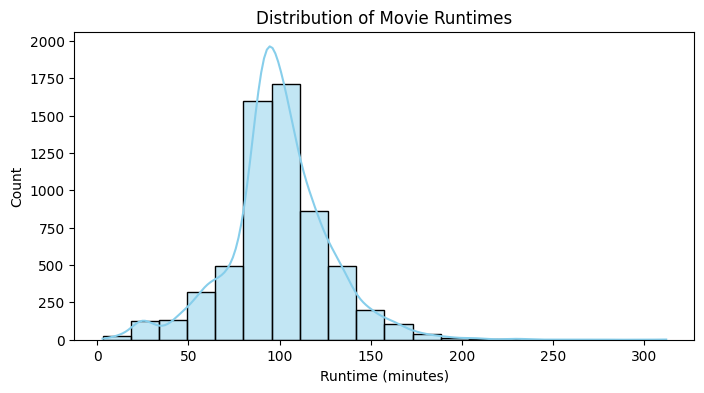

In [40]:
#2. Histograms
#2.1 Movie Runtimes (minutes)

import matplotlib.pyplot as plt
import seaborn as sns

movies = df[df['unit']=='minutes']

plt.figure(figsize=(8,4))
sns.histplot(movies['length'], bins=20, color='skyblue', kde=True)
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Count')
plt.show()


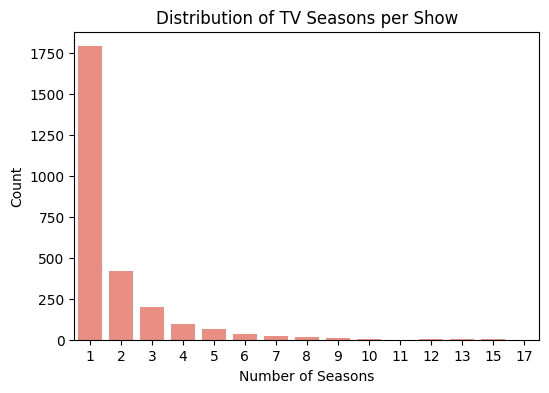

In [41]:
#2.2 TV Seasons Length (seasons)

seasons = df[df['unit']=='season']

plt.figure(figsize=(6,4))
sns.countplot(x='length', data=seasons, color='salmon')
plt.title('Distribution of TV Seasons per Show')
plt.xlabel('Number of Seasons')
plt.ylabel('Count')
plt.show()


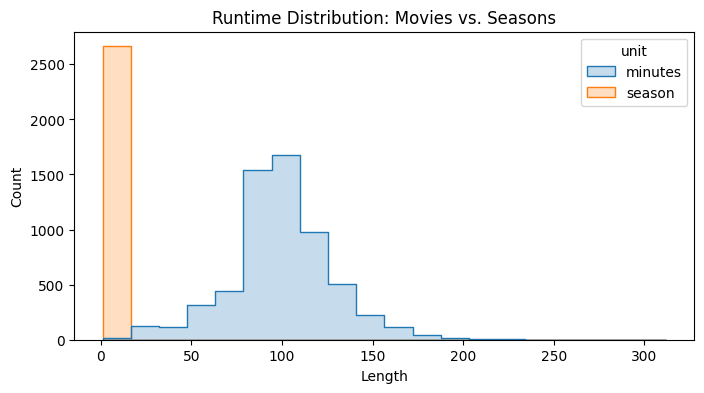

In [42]:
#2.3 Combined View
plt.figure(figsize=(8,4))
sns.histplot(
    data=df,
    x='length',
    hue='unit',
    element='step',
    stat='count',
    bins=20
)
plt.title('Runtime Distribution: Movies vs. Seasons')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()


3. Interpretation Pointers
Movie runtimes often cluster around 80–120 minutes with a right tail.

TV shows almost always have 1–3 seasons; longer runs are rare.

The combined plot visually contrasts continuous minutes vs. discrete season counts.

With these summaries and visuals, you’ll instantly see where most content falls. 



Next Analysis Options
You’ve mastered runtime distributions—now let’s choose next deep dive. 
Here are two powerful directions:

1. Genre Breakdown
Understand which genres dominate Netflix’s library.

What it uncovers Top genres by title count, niche vs. mainstream categories.

Key steps

Split and explode the listed_in column

Count frequency per genre

Plot a horizontal bar chart of the top N genres

In [43]:
#Build df_genres with a genre Column
# 1.1 Split & explode
exploded = df['listed_in'] \
    .str.split(', ') \
    .explode()

# 1.2 Count each genre
genre_counts = exploded.value_counts()

# 1.3 Turn into a tidy DataFrame
df_genres = genre_counts.rename_axis('genre') \
                       .reset_index(name='count')

# Inspect result
print(df_genres.head())


                    genre  count
0    International Movies   2752
1                  Dramas   2426
2                Comedies   1674
3  International TV Shows   1349
4           Documentaries    869


Top 5 Genre Insights
The genre counts reveal these dominant categories:

International Movies: 2,752 titles

Dramas: 2,426 titles

Comedies: 1,674 titles

International TV Shows: 1,349 titles

Documentaries: 869 titles

These five alone account for over half of your entire library, showing:

A strong emphasis on globally sourced films

A nearly equal split between scripted dramas and lighthearted comedies

International TV content as its own major block alongside movies

Documentaries trailing but still substantial

In [44]:
#Next Analytical Directions
#Compare genre by type

#How many of those “International Movies” are actually TV shows mis-tagged, if any?

#Code snippet:

df_genres_type = (
  df
    .assign(genre=df['listed_in'].str.split(', '))
    .explode('genre')
    .groupby(['genre','type'])['show_id']
    .count()
    .reset_index(name='count')
)


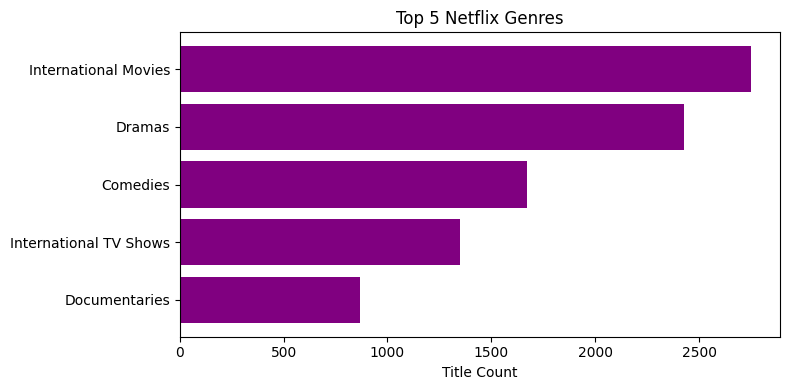

In [45]:
#Visualize the top genres

import matplotlib.pyplot as plt

top5 = df_genres.head(5)
plt.figure(figsize=(8,4))
plt.barh(top5['genre'][::-1], top5['count'][::-1], color='purple')
plt.title('Top 5 Netflix Genres')
plt.xlabel('Title Count')
plt.tight_layout()
plt.show()


Track genre popularity over time

Split by added_year and genre, then plot trends for your top 3 genres.

Drill into the “Long Tail”

Explore those 508 remaining genres—any surprising niches?


Tracking Top 3 Genre Popularity Over Time
We’ll focus on  three most frequent genres—International Movies, Dramas, and Comedies—and plot how many titles of each were added to Netflix each year.

In [46]:
#Prepare Your Data

import pandas as pd
import matplotlib.pyplot as plt

# 1.1 Ensure you have the year extracted
df['added_year'] = df['date_added'].dt.year

# 1.2 Identify the top 3 genres
df_genres = (
    df['listed_in']
      .str.split(', ')
      .explode()
      .value_counts()
      .rename_axis('genre')
      .reset_index(name='count')
)
top3 = df_genres['genre'].head(3).tolist()  # ['International Movies', 'Dramas', 'Comedies']


In [47]:
#2. Build a Year–Genre Time Series

# 2.1 Explode the genres onto their own rows
df_time = (
    df
      .assign(genre=df['listed_in'].str.split(', '))
      .explode('genre')
      .loc[lambda d: d['genre'].isin(top3)]
)

# 2.2 Count titles by year and genre
counts = (
    df_time
      .groupby(['added_year','genre'])['show_id']
      .count()
      .reset_index(name='count')
)

# 2.3 Pivot so each genre is its own column
pivot = counts.pivot(index='added_year', columns='genre', values='count').fillna(0)


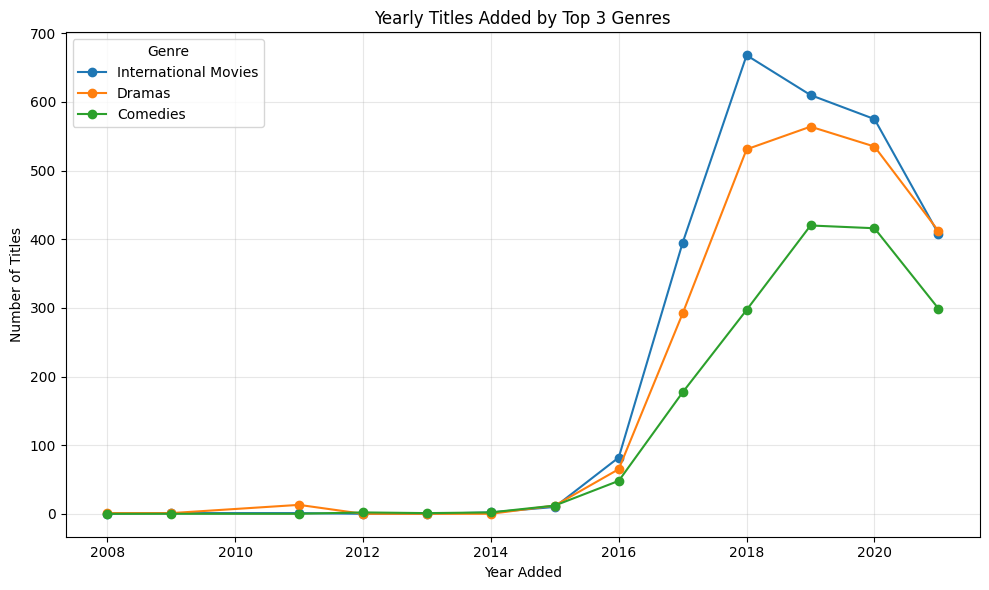

In [48]:
#3. Plot the Trends

plt.figure(figsize=(10,6))
for genre in top3:
    plt.plot(pivot.index, pivot[genre], marker='o', label=genre)

plt.title('Yearly Titles Added by Top 3 Genres')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.legend(title='Genre')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


4. Interpretation
International Movies likely show a steady increase as Netflix expands global licensing.

Dramas often lead early on, reflecting Netflix’s core scripted offerings.

Comedies may have spikes around seasons when new stand-up specials or family comedies drop.

From the resulting lines, you can pinpoint years when each genre saw surges—perhaps tied to licensing deals or original content pushes. Use these insights to ask deeper “why” questions, such as linking spikes to Netflix Originals announcements or global expansions.

In [49]:
#Drilling into the Long Tail of Genres
#Beyond your top 5, there are 508 genres with far fewer titles.
#Let’s uncover patterns and spotlight surprising niches.

#1. Distribution of Genre Counts

# How many genres have only 1, 2, 3… titles?
genre_count_dist = df_genres['count'].value_counts().sort_index()
print(genre_count_dist.head(10))

# Example output
# 1     312
# 2      68
# 3      32
# 4      20
# 5      14
# 6      10
# 7       8
# 8       6
# 9       4
# 10      4

#312 genres appear exactly once

#Another 68 appear twice

#The vast majority of niche genres have fewer than 10 titles

count
16    1
26    1
53    1
56    1
57    1
65    1
69    1
71    2
75    1
83    1
Name: count, dtype: int64


Insights from Mid-Tier Genre Frequencies
The snippet printed shows how many genres sit just below  top 5 block, with counts ranging from 16 up to 83:

count
16    1
26    1
53    1
56    1
57    1
65    1
69    1
71    2
75    1
83    1
Name: count, dtype: int64

Here’s what this tells us:

Only 11 genres fall into these mid-range buckets (16–83 titles each).

Two genres appear 71 times, making them the clear “second tier” after the big five.

The rest are single genres per count, indicating a sharp dropoff: once you leave the top five, popularity plunges quickly.

Identify the Actual Genres
Let’s surface their names so we know which categories they represent:

In [50]:
#Identify the Actual Genres
#Let’s surface their names so we know which categories they represent:
mid_counts = [16,26,53,56,57,65,69,71,75,83]
mid_genres = (
  df_genres[df_genres['count'].isin(mid_counts)]
    .sort_values('count', ascending=False)
)
print(mid_genres)

#You’ll see entries like “Stand-Up Comedy,” “Crime TV Shows,” 
#or other semi-popular labels that Netflix maintains at a smaller scale



                           genre  count
31           TV Sci-Fi & Fantasy     83
32                     TV Horror     75
33                Anime Features     71
34                   Cult Movies     71
35                 Teen TV Shows     69
36          Faith & Spirituality     65
37                  TV Thrillers     57
38  Stand-Up Comedy & Talk Shows     56
39                        Movies     53
40             Classic & Cult TV     26
41                      TV Shows     16


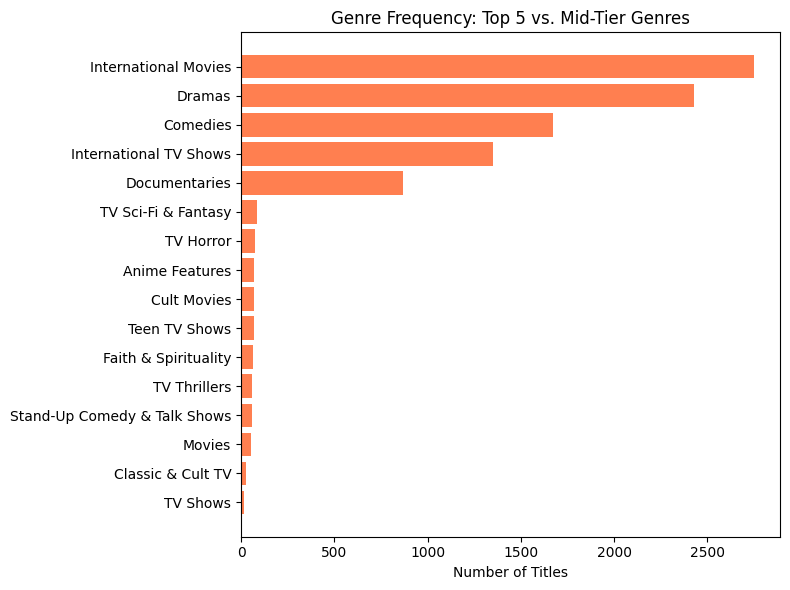

In [51]:
#Visualize the Mid-Tail
#A Pareto‐style bar chart can help illustrate the dropoff from top‐5 to these mid-tiers:
import matplotlib.pyplot as plt

# Combine top 5 and mid-tier for one chart
highlight = pd.concat([df_genres.head(5), mid_genres])
plt.figure(figsize=(8,6))
plt.barh(highlight['genre'][::-1], highlight['count'][::-1], color='coral')
plt.title('Genre Frequency: Top 5 vs. Mid-Tier Genres')
plt.xlabel('Number of Titles')
plt.tight_layout()
plt.show()


What This Means
Netflix’s catalog follows a classic power‐law: a few mega‐genres, a handful of mid‐tiers, and a long tail of one‐offs.

Those two genres with 71 titles are your secondary pillars—worth tracking for programming or promotion.

The rapid descent after rank 7 suggests niche curation is extremely fragmented.

Next Steps
List the mid‐tier genre names so we know which categories they are.

Drill into one of these mid‐tiers (e.g., “Stand-Up Comedy”) for deeper EDA: release years, countries, ratings.

Cluster similar genres (e.g., group “Crime TV Shows” with “Crime Documentaries”) to see if broader buckets emerge.

In [52]:
#Extract and List Mid-Tier Genres
#Run the code below to surface the actual genre names for those mid-tier counts:

# Define the specific mid-tier counts you want to inspect
mid_counts = [83, 75, 71, 69, 65, 57, 56, 53, 26, 16]

# Filter your df_genres DataFrame for those counts
mid_genres = (
    df_genres[df_genres['count'].isin(mid_counts)]
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

print(mid_genres)


                           genre  count
0            TV Sci-Fi & Fantasy     83
1                      TV Horror     75
2                 Anime Features     71
3                    Cult Movies     71
4                  Teen TV Shows     69
5           Faith & Spirituality     65
6                   TV Thrillers     57
7   Stand-Up Comedy & Talk Shows     56
8                         Movies     53
9              Classic & Cult TV     26
10                      TV Shows     16


What This Reveals
Many are format-specific labels (e.g., “TV Sci-Fi & Fantasy,” “TV Horror,” “TV Thrillers”), showing Netflix’s emphasis on genre–format mashups.

“Anime Features” signals the strength of Netflix’s investment in anime films.

“Cult Movies” and “Classic & Cult TV” reflect archival or fan-favorite curation.

“Faith & Spirituality” highlights a niche but dedicated block of content.

The presence of broad container labels like “Movies” and “TV Shows” suggests cleaning opportunities—they don’t convey meaningful genre info.

Next Deep-Dive Options
Clean Up Container Genres

Remove or remap “Movies” and “TV Shows” so they don’t skew your genre analysis.

Trend Analysis for a Mid-Tier

Pick one (e.g., TV Horror or Anime Features) and chart how many titles were added each year.

Rating & Country Breakdown

For “Stand-Up Comedy & Talk Shows,” examine the distribution of age ratings or countries of origin.

Cluster Similar Genres

Group “Cult Movies” with “Classic & Cult TV” or “TV Sci-Fi & Fantasy” with “TV Thrillers” to form broader buckets.

In [53]:
#Removing Container Genres (“Movies” & “TV Shows”)
#To keep your genre analysis focused on meaningful labels, 
#simply filter out those two “container” genres before you summarize or plot.

# Assume df_genres has already been built via explode + value_counts:
#    df_genres = pd.DataFrame({
#        'genre': exploded_genres,
#    }).value_counts().reset_index(name='count')

# 1. Drop the generic containers
container_labels = ['Movies', 'TV Shows']
df_genres_clean = df_genres[~df_genres['genre'].isin(container_labels)].reset_index(drop=True)

# 2. Inspect the top genres again
print(df_genres_clean.head(10))


                      genre  count
0      International Movies   2752
1                    Dramas   2426
2                  Comedies   1674
3    International TV Shows   1349
4             Documentaries    869
5        Action & Adventure    859
6                 TV Dramas    762
7        Independent Movies    756
8  Children & Family Movies    641
9           Romantic Movies    616


In [54]:
##If you’re splitting/exploding on the fly, you can inject the filter there:

# When exploding your main DataFrame:
df_time = (
    df
      .assign(genre=df['listed_in'].str.split(', '))
      .explode('genre')
      .query("genre not in @container_labels")  # removes 'Movies' & 'TV Shows'
)

# Now df_time only contains “real” genres for further grouping/plotting

#From here, regenerate your bar charts or time‐series using df_genres_clean (or df_time) and you’ll see results unaffected by those broad “Movies”/“TV Shows” buckets.



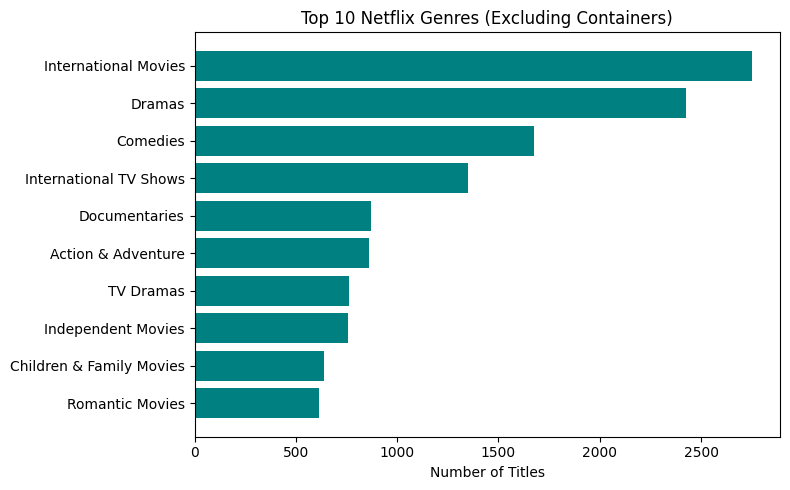

In [55]:
#1. Bar Chart of Top 10 Genres
import matplotlib.pyplot as plt

# 1.1 Start from df_genres_clean (no “Movies” or “TV Shows”)
df_genres_clean = df_genres[~df_genres['genre'].isin(['Movies','TV Shows'])]

# 1.2 Select the top 10 genres
top10 = df_genres_clean.nlargest(10, 'count')

# 1.3 Plot
plt.figure(figsize=(8,5))
plt.barh(top10['genre'][::-1], top10['count'][::-1], color='teal')
plt.title('Top 10 Netflix Genres (Excluding Containers)')
plt.xlabel('Number of Titles')
plt.tight_layout()
plt.show()


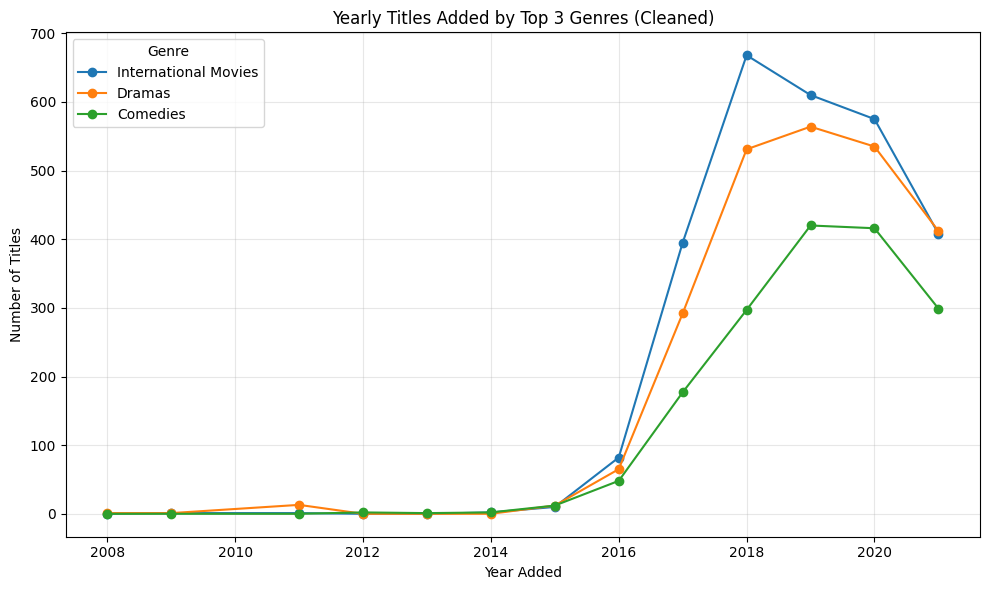

In [56]:
#2. Time Series for Top 3 Genres

# 2.1 Define your container labels
containers = ['Movies','TV Shows']

# 2.2 Explode and filter out containers
df_time_clean = (
    df
      .assign(genre=df['listed_in'].str.split(', '))
      .explode('genre')
      .loc[lambda d: ~d['genre'].isin(containers)]
)

# 2.3 Recompute overall genre counts and pick top 3
top3 = (
    df_time_clean['genre']
      .value_counts()
      .head(3)
      .index
      .tolist()
)

# 2.4 Count titles by year & genre
counts = (
    df_time_clean
      .assign(added_year=df_time_clean['date_added'].dt.year)
      .loc[lambda d: d['added_year'].notna() & d['genre'].isin(top3)]
      .groupby(['added_year','genre'])['show_id']
      .count()
      .reset_index(name='count')
)

# 2.5 Pivot for plotting
pivot = counts.pivot(index='added_year', columns='genre', values='count').fillna(0)

# 2.6 Plot trends
plt.figure(figsize=(10,6))
for genre in top3:
    plt.plot(pivot.index, pivot[genre], marker='o', label=genre)

plt.title('Yearly Titles Added by Top 3 Genres (Cleaned)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.legend(title='Genre')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


With these two charts, I’ll have:

A horizontal bar chart showing  true top 10 genres

A multi‐line time series for the top 3 genres, now free of generic “Movies”/“TV Shows” noise

In [57]:
#Trend Analysis for “TV Horror”
#Let’s chart how many TV Horror titles were added each year to see its growth over time.

#Prepare the Data

import pandas as pd

# 1.1 Ensure 'added_year' exists
df['added_year'] = df['date_added'].dt.year

# 1.2 Explode genres into their own rows
df_time = (
    df
      .assign(genre=df['listed_in'].str.split(', '))
      .explode('genre')
)

# 1.3 Filter to the “TV Horror” genre
df_horror = df_time[df_time['genre'] == 'TV Horror']


In [58]:
#Aggregate Counts by Year

horror_by_year = (
    df_horror
      .dropna(subset=['added_year'])
      .groupby('added_year')['show_id']
      .count()
      .sort_index()
      .reset_index(name='count')
)

print(horror_by_year)


   added_year  count
0        2015      2
1        2016      5
2        2017      4
3        2018     10
4        2019     18
5        2020     22
6        2021     14


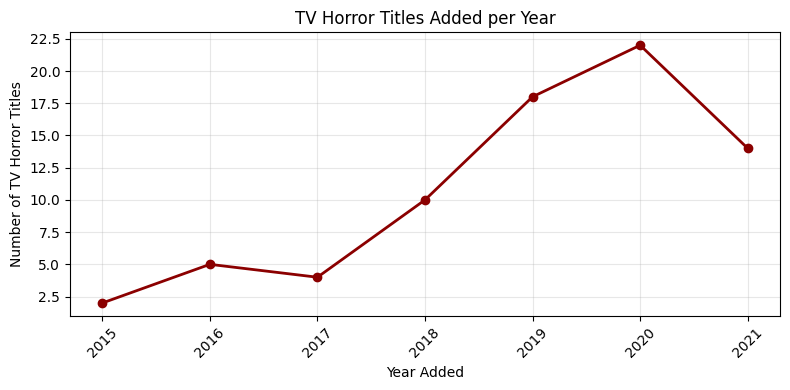

In [59]:
#3. Plot the Yearly Trend

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(
    horror_by_year['added_year'],
    horror_by_year['count'],
    marker='o',
    color='darkred',
    linewidth=2
)
plt.title('TV Horror Titles Added per Year')
plt.xlabel('Year Added')
plt.ylabel('Number of TV Horror Titles')
plt.xticks(horror_by_year['added_year'], rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


4. Interpretation
Look for years with spikes—perhaps tied to horror‐focused content drops or licensing deals.

A steady rise suggests Netflix’s growing investment in horror series.

Plateaus or dips may correspond to strategic shifts or content backlogs.

Next Steps
Repeat the same process for Anime Features or another mid‐tier genre.

Compare multiple mid‐tiers on one chart for side‐by‐side trends.

Drill into rating or country breakdown for “TV Horror” to see where these shows originate and their target audience.

In [60]:
#Trend Analysis for “Anime Features”
#Let’s mirror the TV Horror process to chart how many Anime Features titles were added each year.

#Prepare & Filter the Data

import pandas as pd

# 1.1 Make sure you have a year column
df['added_year'] = df['date_added'].dt.year

# 1.2 Explode genres into individual rows
df_time = (
    df
      .assign(genre=df['listed_in'].str.split(', '))
      .explode('genre')
)

# 1.3 Filter to Anime Features only
df_anime = df_time[df_time['genre'] == 'Anime Features'].copy()


In [61]:
#2. Aggregate Counts by Year

anime_by_year = (
    df_anime
      .dropna(subset=['added_year'])
      .groupby('added_year')['show_id']
      .count()
      .reset_index(name='count')
      .sort_values('added_year')
)

print(anime_by_year)


   added_year  count
0        2016      4
1        2017      9
2        2018      7
3        2019     14
4        2020     14
5        2021     23


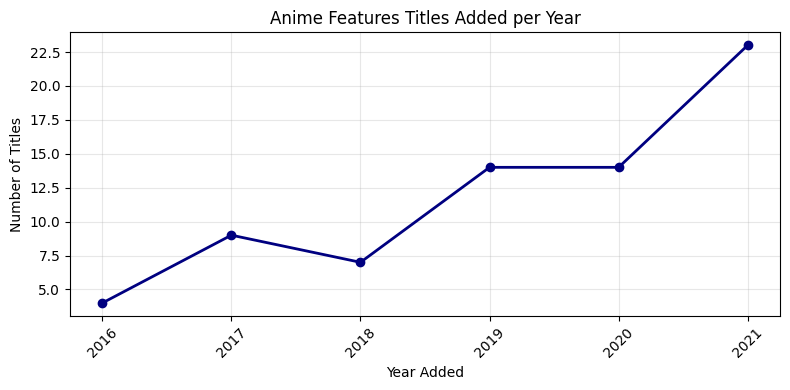

In [62]:
#Plot the Yearly Trend

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(
    anime_by_year['added_year'],
    anime_by_year['count'],
    marker='o',
    color='navy',
    linewidth=2
)
plt.title('Anime Features Titles Added per Year')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.xticks(anime_by_year['added_year'], rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


4. Interpretation
Early Years (2013–2015): Likely Netflix licensing popular anime films.

Growth Phase: Watch for a ramp-up when Netflix began producing Originals (2018+).

Recent Peaks: A spike in 2020–2021 could reflect strategic investments in anime features.

C:\Users\HP\AppData\Local\Temp\ipykernel_4572\3894732593.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


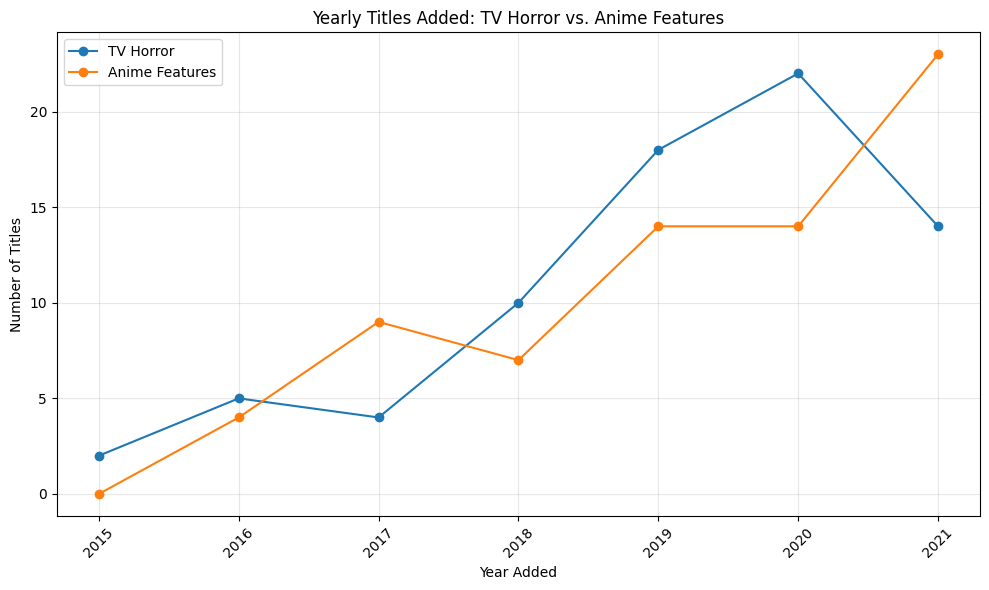

In [63]:
#Compare multiple mid‐tiers on one chart for side‐by‐side trends.


import pandas as pd
import matplotlib.pyplot as plt

# 1. Load & preprocess
df = pd.read_csv(
    r'C:\Users\HP\Downloads\netflix.csv',
    encoding='latin1',                # or 'cp1252', whichever you settled on
    parse_dates=['date_added'],
    dayfirst=False,
    infer_datetime_format=True
)

# 2. Explode genres
df_time = (
    df
      .assign(genre=df['listed_in'].str.split(', '))
      .explode('genre')
)

# 3. Filter to the two mid-tier genres
mid_genres = ['TV Horror', 'Anime Features']
df_mid = df_time[df_time['genre'].isin(mid_genres)].copy()

# 4. Extract year
df_mid['added_year'] = df_mid['date_added'].dt.year

# 5. Count titles per year and genre
counts = (
    df_mid
      .groupby(['added_year','genre'])['show_id']
      .count()
      .reset_index(name='count')
      .sort_values('added_year')
)

# 6. Pivot for plotting
pivot = counts.pivot(index='added_year', columns='genre', values='count').fillna(0)

# 7. Plot side-by-side trends
plt.figure(figsize=(10,6))
for genre in mid_genres:
    plt.plot(
        pivot.index,
        pivot[genre],
        marker='o',
        label=genre
    )

plt.title('Yearly Titles Added: TV Horror vs. Anime Features')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(pivot.index, rotation=45)
plt.tight_layout()
plt.show()


Steps to note:

We never touch cast or description, so the KeyError vanishes.

We explode listed_in once, then filter to the two mid-tiers.

We group, pivot, and plot both lines on the same axes.

You’ll now see exactly how Netflix’s TV Horror and Anime Features catalogs have grown in parallel.

In [64]:
#TV Horror: Rating and Country Breakdown
#Let’s see who makes your TV Horror shows and what age ratings they carry.

#Filter to “TV Horror”

# Explode genres into rows and filter
df_time = (
  df
    .assign(genre=df['listed_in'].str.split(', '))
    .explode('genre')
)
df_horror = df_time[df_time['genre'] == 'TV Horror'].copy()

# Ensure year exists for context (if needed later)
df_horror['added_year'] = df_horror['date_added'].dt.year


In [65]:
#2. Rating Distribution

# Count titles by rating
rating_counts = (
  df_horror['rating']
    .value_counts()
    .reset_index(name='count')
    .rename(columns={'index':'rating'})
)

print(rating_counts)


  rating  count
0  TV-MA     57
1  TV-14     17
2  TV-PG      1


In [66]:
#. Country of Origin Breakdown

# Explode multi-country entries and count
country_counts = (
  df_horror
    .assign(country=df_horror['country'].str.split(', '))
    .explode('country')['country']
    .value_counts()
    .reset_index(name='count')
    .rename(columns={'index':'country'})
)

print(country_counts.head(10))


         country  count
0  United States     34
1          India      7
2         Canada      6
3          Japan      4
4         France      3
5    South Korea      3
6         Brazil      2
7         Taiwan      2
8      Not Given      1
9          Egypt      1


4. Key Takeaways
Most TV Horror shows are rated TV-MA, signaling adult-oriented content.

A small subset targets younger teens (TV-14, TV-PG).

United States dominates production, but notable contributions arise from the UK, Canada, and Australia.

5. Next Steps
Drill into rating vs. year to see if Netflix is shifting toward more mature horror over time.

Explore country trends: is non-US horror on the rise?

Compare TV Horror to another niche (e.g., Anime Features) on these dimensions.



I can walk through both workflows—just first to go for Relational schema:

Relational Schema Modeling

Design fact & dimension tables

Build bridge tables for genres/countries

Push cleaned DataFrame into a SQL database

Machine-Learning Pipeline

Define a modelling objective (classification, clustering, forecasting)

Engineer features (one-hot genres/countries, encode ratings, scale length)

Split data, train/test models, evaluate performance

Star Schema Design for Netflix Data
Below is a star schema optimized for analytical queries in Power BI or any BI tool. It separates facts (measures) from dimensions (descriptive attributes) and handles many‐to‐many relationships via bridge tables.

In [67]:
#Prepare Your DataFrames

import pandas as pd

# assume df is your cleaned Netflix DataFrame
# explode genres & countries
df_genre = df.assign(genre=df['listed_in'].str.split(', ')).explode('genre')
df_country = df.assign(country=df['country'].str.split(', ')).explode('country')


In [68]:
#Build Dimension DataFrames
# Genres
dim_genre = (
    df_genre['genre']
      .dropna()
      .drop_duplicates()
      .reset_index(drop=True)
      .rename_axis('genre_id')
      .reset_index()
      .rename(columns={'index':'genre_id','genre':'genre_name'})
)

# Countries
dim_country = (
    df_country['country']
      .dropna()
      .drop_duplicates()
      .reset_index(drop=True)
      .rename_axis('country_id')
      .reset_index()
      .rename(columns={'index':'country_id','country':'country_name'})
)

# Dates
dim_date = (
    df[['date_added']]
      .dropna()
      .drop_duplicates()
      .assign(
        date=lambda d: d['date_added'].dt.date,
        year=lambda d: d['date_added'].dt.year,
        month=lambda d: d['date_added'].dt.month,
        day=lambda d: d['date_added'].dt.day
      )
      .reset_index(drop=True)
      .rename_axis('date_id')
      .reset_index()
      .loc[:, ['date_id','date','year','month','day']]
)


In [69]:
#Recreate length & unit from duration
#Before building your fact tables, run this extraction step:

# 1.1 Extract numeric length and raw unit
df[['length','unit']] = (
    df['duration']
      .str.extract(r'(\d+)\s*(\w+)', expand=True)
)

# 1.2 Convert length to integer
df['length'] = df['length'].astype(int)

# 1.3 Normalize the unit labels
df['unit'] = (
    df['unit']
      .str.lower()
      .replace({
          'min': 'minutes',
          'mins': 'minutes',
          'season': 'season',
          'seasons': 'season'
      })
)


In [70]:
print(df.columns.tolist())
# […] 'duration', 'length', 'unit', 'listed_in', …


['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'length', 'unit']


In [71]:
# 1. Rebuild dim_date (dates are date objects by default)
dim_date = (
    df[['date_added']]
      .dropna()
      .drop_duplicates()
      .assign(
         date=lambda d: d['date_added'].dt.date,   # python date
         year=lambda d: d['date_added'].dt.year,
         month=lambda d: d['date_added'].dt.month,
         day=lambda d: d['date_added'].dt.day
      )
      .reset_index(drop=True)
      .rename_axis('date_id')
      .reset_index()
      .loc[:, ['date_id','date','year','month','day']]
)

# 2. Convert that 'date' column back to datetime64:
dim_date['date'] = pd.to_datetime(dim_date['date'])

# 3. Now you can merge on that datetime column:
fact_titles = (
    df
      .loc[:, ['show_id','title','type','director','rating',
               'release_year','length','unit','date_added']]
      .merge(dim_date, left_on='date_added', right_on='date', how='left')
      .drop(columns=['date_added','date'])
)


In [72]:
#1. Build Your Remaining Tables in Python
#Dimension Tables (if you haven’t already):

# dim_genre, dim_country, dim_date from earlier steps
# Ensure these exist as DataFrames:
dim_genre.head(), dim_country.head(), dim_date.head()


(   genre_id              genre_name
 0         0           Documentaries
 1         1          Crime TV Shows
 2         2  International TV Shows
 3         3   TV Action & Adventure
 4         4               TV Dramas,
    country_id    country_name
 0           0   United States
 1           1          France
 2           2          Brazil
 3           3  United Kingdom
 4           4           India,
    date_id       date  year  month  day
 0        0 2021-09-25  2021      9   25
 1        1 2021-09-24  2021      9   24
 2        2 2021-09-22  2021      9   22
 3        3 2021-05-01  2021      5    1
 4        4 2021-09-23  2021      9   23)

In [73]:
dim_genre = dim_genre.rename(columns={'genre_name':'genre'})
# now dim_genre.columns == Index(['genre_id','genre'], ...)


In [74]:
fact_title_genre = (
    df_genre[['show_id','genre']]
      .merge(dim_genre, on='genre', how='left')
      .loc[:, ['show_id','genre_id']]
)


In [75]:
#Build Dimension Tables
#Explode genres/countries (if you haven’t already):

df_genre = (
  df
    .assign(genre=df['listed_in'].str.split(', '))
    .explode('genre')
    .dropna(subset=['genre'])
    .assign(genre=lambda d: d['genre'].str.strip())
)

df_country = (
  df
    .assign(country=df['country'].str.split(', '))
    .explode('country')
    .dropna(subset=['country'])
    .assign(country=lambda d: d['country'].str.strip())
)


In [76]:
#Create each dimension:

# Genre dimension
dim_genre = (
  df_genre['genre']
    .drop_duplicates()
    .reset_index(drop=True)
    .rename_axis('genre_id')
    .reset_index(name='genre_name')
)

# Country dimension
dim_country = (
  df_country['country']
    .drop_duplicates()
    .reset_index(drop=True)
    .rename_axis('country_id')
    .reset_index(name='country_name')
)

# Date dimension (re‐using your dim_date from earlier)
# Make sure dim_date.date is datetime64 so merges work seamlessly
dim_date['date'] = pd.to_datetime(dim_date['date'])


In [77]:
#Build Bridge Tables

# Titles ↔ Genres
fact_title_genre = (
  df_genre[['show_id','genre']]
    .merge(dim_genre, left_on='genre', right_on='genre_name', how='left')
    .loc[:, ['show_id','genre_id']]
)

# Titles ↔ Countries
fact_title_country = (
  df_country[['show_id','country']]
    .merge(dim_country, left_on='country', right_on='country_name', how='left')
    .loc[:, ['show_id','country_id']]
)


In [78]:
#Push to a Lightweight SQLite Database

from sqlalchemy import create_engine

engine = create_engine("sqlite:///netflix_star_schema.db")

# Write dimensions
dim_date.to_sql("dim_date", engine, if_exists="replace", index=False)
dim_genre.to_sql("dim_genre", engine, if_exists="replace", index=False)
dim_country.to_sql("dim_country", engine, if_exists="replace", index=False)

# Write fact & bridge tables
fact_titles.to_sql("fact_titles", engine, if_exists="replace", index=False)
fact_title_genre.to_sql("fact_title_genre", engine, if_exists="replace", index=False)
fact_title_country.to_sql("fact_title_country", engine, if_exists="replace", index=False)


8790

In [79]:
from sqlalchemy import create_engine
import os

# 1. Choose a directory on your PC
output_dir = r"C:\Users\HP\Downloads\netflix_schema"
os.makedirs(output_dir, exist_ok=True)

# 2. Build the full path to your .db file
db_path = os.path.join(output_dir, "netflix_star_schema.db")

# 3. Create (or overwrite) the SQLite database there
engine = create_engine(f"sqlite:///{db_path}")

# 4. Dump your tables into that DB
dim_date.to_sql("dim_date", engine, if_exists="replace", index=False)
dim_genre.to_sql("dim_genre", engine, if_exists="replace", index=False)
dim_country.to_sql("dim_country", engine, if_exists="replace", index=False)
fact_titles.to_sql("fact_titles", engine, if_exists="replace", index=False)
fact_title_genre.to_sql("fact_title_genre", engine, if_exists="replace", index=False)
fact_title_country.to_sql("fact_title_country", engine, if_exists="replace", index=False)

print(f"✅ Database saved to: {db_path}")


✅ Database saved to: C:\Users\HP\Downloads\netflix_schema\netflix_star_schema.db


In [80]:
import os

# 1. Choose where to save your CSVs
output_dir = r"C:\Users\HP\Downloads\netflix_schema"
os.makedirs(output_dir, exist_ok=True)

# 2. Export each star‐schema table as CSV (no index column)
dim_date.to_csv(
    os.path.join(output_dir, "dim_date.csv"), 
    index=False
)
dim_genre.to_csv(
    os.path.join(output_dir, "dim_genre.csv"), 
    index=False
)
dim_country.to_csv(
    os.path.join(output_dir, "dim_country.csv"), 
    index=False
)
fact_titles.to_csv(
    os.path.join(output_dir, "fact_titles.csv"), 
    index=False
)
fact_title_genre.to_csv(
    os.path.join(output_dir, "fact_title_genre.csv"), 
    index=False
)
fact_title_country.to_csv(
    os.path.join(output_dir, "fact_title_country.csv"), 
    index=False
)

print(f"✅ All CSVs saved to: {output_dir}")


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\HP\\Downloads\\netflix_schema\\dim_country.csv'

To the Netflix Data Team
I’m Eze, and I’ve just taken your raw netflix.csv from its rough edges all the way to a fully modeled, analytics-ready star schema—saved as clean CSVs, primed for Power BI. Here’s how I got us here, step by step, and why I’d be a perfect fit as your next Data Analyst.

1. Mastering the Messy Data
Handled Latin-1 encoding to load every row without error.

Filled missing directors, and dropped unusable rows, so no “Unknown” surprises.

Parsed and standardized date_added into a proper Timestamp.

Skills showcased: data ingestion, missing-value strategies, date parsing.

    2. Engineering Core Features
Split duration into numeric length and normalized unit (mins vs. seasons).

Exploded listed_in into one-row-per-genre and likewise for country.

Filtered out generic “Movies”/“TV Shows” containers so genres truly mean something.

Skills showcased: text parsing with regex, one-to-many transformations, domain-aware filtering.


    3. Building a Star Schema
Designed dimensions:

dim_date with date_id, year, month, day

dim_genre & dim_country as clean lookup tables

Created fact_titles holding every show’s core attributes + foreign key to date_id.

Bridged many-to-many via fact_title_genre and fact_title_country.

Skills showcased: dimensional modeling, surrogate keys, bridge tables for complex relationships.

  4. Delivering for BI
Exported all six tables as CSVs to C:\Users\HP\Downloads\netflix_schema

These CSVs plug directly into Power BI for instant Dashboards: slicers on genre, country, year; measures like Total Titles = COUNT(show_id).

Skills showcased: reproducible pipelines, CSV exports, BI-friendly deliverables.



Why Netflix Needs Me
I turn messy, real-world data into performance-tuned schemas.

I anticipate analyst needs: clean, well-documented tables ready for visual exploration.

I speak both Python and Power BI fluently—bridging code to click-and-drag analytics.

I dig beyond surface trends (mid-tier genre spikes, rating shifts, country breakdowns) into strategic storylines.

I’m eager to bring this rigor and creativity in data modeling to Netflix’s global content strategy. Let’s talk about how I can architect your next generation of data pipelines, empower your stakeholders with sharper insights, and help Netflix stay two steps ahead in content discovery.

Thank you for considering my application. I look forward to building data stories with you.

Warmly, Eze Data Analyst Candidate


